In [0]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import circulant, block_diag
import time
import cvxpy as cvx

In [0]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/35c067adcc1ab364c8803830cdb34d0d50eea37e/week01_backprop/mnist.py -O mnist.py

--2020-05-12 08:52:21--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/35c067adcc1ab364c8803830cdb34d0d50eea37e/week01_backprop/mnist.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2697 (2.6K) [text/plain]
Saving to: ‘mnist.py’

mnist.py            100%[===================>]   2.63K  --.-KB/s    in 0s      

2020-05-12 08:52:21 (44.5 MB/s) - ‘mnist.py’ saved [2697/2697]



In [0]:
import mnist

In [0]:
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset(flatten=True)

In [0]:
pic1 = X_train[0].reshape([28,28])
pic2 = X_train[1].reshape([28,28])

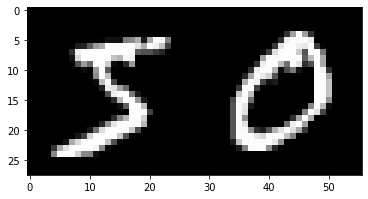

In [0]:
ims = np.hstack((pic1,pic2))
plt.imshow(ims,'gray')

In [0]:
np.savetxt("digit.csv", ims, delimiter=",")

In [0]:
K = 10
L = 1500
N = 2*784

In [0]:

m = pic1.reshape((784,1))
m2 = pic2.reshape((784,1))
m1 = np.vstack((m,m2))

In [0]:
C = np.random.randn(L,N)
h1 = np.random.randn(K,1)
h2 = np.random.randn(K,1)
#h3 = np.random.randn(K,1)
#h4 = np.random.randn(K,1)
#h5 = np.random.randn(K,1)
B = np.random.randn(L,K)

In [0]:
A = circulant(C[:,0]) @ B
for iter in range(1,N):
    elem = circulant(C[:,iter]) @ B
    A = np.hstack((A,elem))

In [0]:
X1 = h1 @ m1.reshape((1,N))
X2 = h2 @ m1.reshape((1,N))
#X3 = h3 @ m1.reshape((1,N))
#X4 = h4 @ m1.reshape((1,N))
#X5 = h5 @ m1.reshape((1,N))
X = np.vstack((X1,X2))

In [0]:
A = block_diag(A,A)

In [0]:
y =  A @ X.reshape((2*N*K,1))

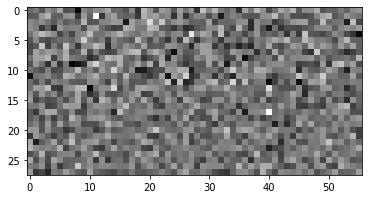

In [0]:
plt.imshow(y[:N].reshape(28,56),'gray')

In [0]:

def prox_nuclear(A, lambd):
    U, S, Vh = np.linalg.svd(A)
    svp = np.sum(S > lambd)
    if svp >= 1:
        S = S[:svp] - lambd
        X = U[:,:svp] @ np.diag(S) @ Vh[:svp]
        nucnorm = np.sum(S)
    else:
        X = np.zeros(A.shape)
        nucnorm = 0
    return X, nucnorm

In [0]:
def prox_l21(A,lambd):
    X = np.zeros(A.shape)
    for i in range(X.shape[1]):
        nxi = np.linalg.norm(A[:,i])
        if nxi > lambd:
            X[:,i] = (1 - lambd/nxi) * A[:,i]
    return X
    

In [0]:
def lrr(y, A, lambd):
    tol = 1e-4
    max_iter = 500
    ro = 1.1
    mu = 1e-4
    max_mu = 1e10

    d, na = y.shape
    a, nb = A.shape
    #X = np.zeros((nb, na))
    X = np.zeros((2*K,N))
    E = np.zeros((d, na))
    J = X

    Y1 = E
    Y2 = X
   
    Ablock = A[:int(a/2),:int(nb/2)]

    AtA = Ablock.T @ Ablock
    Aty = A.T @ y
    I = np.eye(int(nb/2))
    invAtAIblock = np.linalg.inv(AtA + I)
   
    invAtAI = block_diag(invAtAIblock,invAtAIblock)
  
    errs = []
    times = []
    start = time.time()

    for iter in range(max_iter):
      

        J, nuclearnormJ = prox_nuclear(X+Y2/mu, 1/mu)
        E = prox_l21(y - A @ X.reshape((2*K*N,1)) + Y1/mu, lambd/mu)

        X = (invAtAI @ ((A.T @ (Y1/mu -E) + Aty).reshape((2*K,N)) - Y2/mu + J).reshape((2*K*N,1))).reshape((2*K,N))
        dY1 = y - A @ X.reshape((2*K*N,1)) - E
        dY2 = X - J

        Y1 += mu * dY1
        Y2 += mu * dY2
        mu = min(ro*mu, max_mu)
        times.append(time.time() - start)
       
        metric = np.linalg.norm(y - A @ X.reshape((2*K*N,1)))
        #print(metric)
        errs.append(metric)
        if metric < tol:
            break
    return J, E, errs, iter, times

In [0]:
Xk, E, errs, iters, times = lrr(y, A, 100)

In [0]:
u, s, v = np.linalg.svd(Xk)

In [0]:
s

array([6.14057033e+01, 1.05841686e+00, 8.83265989e-01, 7.36369161e-01,
       6.83024334e-01, 6.16749322e-01, 5.85626217e-01, 4.23177794e-01,
       3.30577276e-01, 2.78551836e-01, 2.56242862e-01, 2.26508533e-01,
       1.98108942e-01, 9.61485067e-02, 5.24663378e-02, 1.52502197e-02,
       2.47472159e-03, 1.51671605e-03, 9.70135495e-04, 7.56708116e-04])

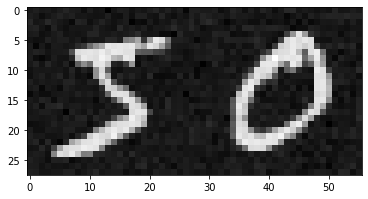

In [0]:

im1 = (v[0,:784]).reshape((28,28))
im2 = (v[0,784:]).reshape((28,28))
im = np.hstack((im1,im2))
plt.imshow(im,'gray')

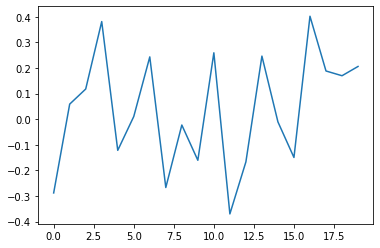

In [0]:
plt.plot(u[:,0])

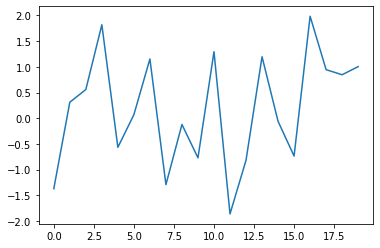

In [0]:
plt.plot(np.vstack((h1,h2)))

In [0]:
times[-1]

296.24458169937134

In [0]:
def sae(s1, s2):
    return np.arccos((s1 @ s2) / (np.linalg.norm(s1) * np.linalg.norm(s2))) ** 2

In [0]:
sae(v[0,:],m1)

array([0.01041559])

In [0]:
sae(u[:,0],np.vstack((h1,h2)))

array([0.00050323])

In [0]:

np.savetxt("imadmm1.csv", v[0,:], delimiter=",")

In [0]:
w1 = B @ h1

In [0]:
g = np.convolve(m1.reshape(N,),w1.reshape(L,),'same')

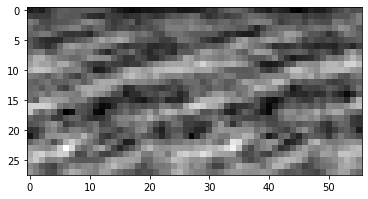

In [0]:
plt.imshow(g.reshape(28,56),'gray')

In [0]:
y =  A @ cvx.vec(X)

In [0]:
start = time.time()
W1 = cvx.Variable((2*K,2*K), symmetric=True)
W2 = cvx.Variable((N,N),  symmetric=True)
Z = cvx.Variable((2*K,N))

constraints = [cvx.bmat([[W1,Z],[Z.T,W2]]) >> 0,
               y == A @ cvx.vec(Z)]
obj = cvx.Minimize(1/2 * (cvx.trace(W1) + cvx.trace(W2)))
problem = cvx.Problem(obj, constraints)
problem.solve()
print(start - time.time())

-1580.6863689422607


In [0]:
Xk = Z.value

In [0]:
u, s, v = np.linalg.svd(Xk)

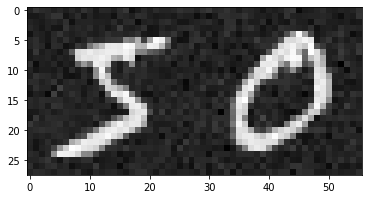

In [0]:

im1 = (v[0,:784]).reshape((28,28))
im2 = (v[0,784:]).reshape((28,28))
im = np.hstack((im1,im2))
plt.imshow(im,'gray')

In [0]:
sae(v[0,:],m1)

array([0.02020709])

In [0]:
sae(u[:,0],np.vstack((h1,h2)))

array([0.00042187])

In [0]:
np.savetxt("imtrace.csv", v[0,:], delimiter=",")